# Predict TripAdvisor Rating

This Dataset gives us information about 40000 European restaurants. Using this data I will make a prediction of the restaurant's TripAdvisor rating depend on their different characteristic.

In [869]:
import pandas as pd
import numpy as np
import math
import re
import datetime
from datetime import datetime, timedelta
import collections
import matplotlib.pyplot as plt
import random
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
pd.set_option('display.max_rows', 50) #to show more rows
pd.set_option('display.max_columns', 50) #to show more columns
#Let's import some more libraries for Machine learning:
from sklearn.model_selection import train_test_split #tool for spliting to Data set for training of the model and the target value 
from sklearn.ensemble import RandomForestRegressor #tool to create and learn a model
from sklearn import metrics #tool for model accuracy estimation

In [870]:
RANDOM_SEED = 42 #to reproduce the data given by a pseudo-random number generator

In [871]:
!pip freeze > requirements.txt

In [872]:
df = pd.read_csv('main_task.csv')
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [873]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Cleaning and Prepping Data

Let's check whether we have some None data:

In [874]:
df.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

There is failing information in 'Cuisine Style', 'Price Range', 'Number of Reviews'. Let's see each of these columns more exactly to see how we can fix them.

For 'Cuisine Style' we can find the most popular style and use it for blanks

In [875]:
styles=df['Cuisine Style'].str.replace('[', '')
styles=styles.str.replace(']', '')
styles=styles.str.replace("'", "")
styles=styles.str.replace(" ", "")
styles=styles.str.split(',')

In [876]:
c=collections.Counter()

In [877]:

for i in styles:
    if str(i)!="nan" and str(i)!="None":
        
        for j in i:
            
            c[j]+=1
        
           
    else:
        continue

styles_counted_df=pd.Series(c)
        

display(styles_counted_df.sort_values(ascending=False))

VegetarianFriendly    11189
European              10060
Mediterranean          6277
Italian                5964
VeganOptions           4486
                      ...  
Salvadoran                1
Yunnan                    1
Xinjiang                  1
Burmese                   1
Latvian                   1
Length: 125, dtype: int64

We counted that the most frequent cuisine style is "Vegetarian Friendly". However, it does not seem like an independent style. That's why for None filling I prepare to take the next most common option - "European". Furthermore "European" concludes more other widespread styles.

In [878]:
df['Cuisine Style'].fillna(value="European", inplace=True)

For the better readability I suggest to rename values of 'Price Range' to "1", "2", "3"

In [879]:
df['Price Range']=df['Price Range'].replace('$', 1)
df['Price Range']=df['Price Range'].replace('$$ - $$$', 2)
df['Price Range']=df['Price Range'].replace('$$$$', 3)


Let's check the ratio of different values compare to None amount:

2.0    18412
nan    13886
1.0     6279
3.0     1423
Name: Price Range, dtype: int64


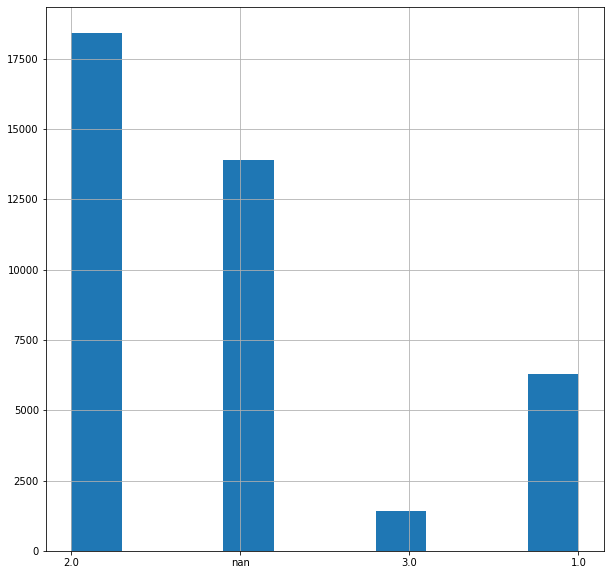

In [880]:
print(df['Price Range'].astype(str).value_counts())
df['Price Range'].astype(str).hist()

I suggest to fill the blanks with "0".

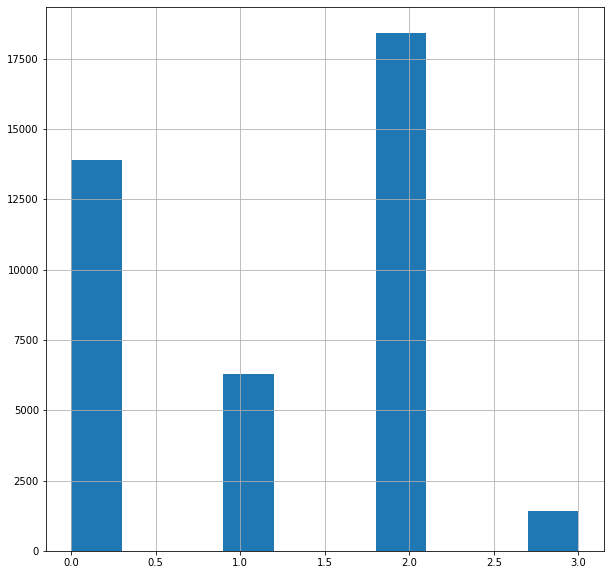

In [881]:
df['Price Range'].fillna(0, inplace=True)
df['Price Range'].hist()

The next column with None values is "Number of Reviews". It contains numeric values. To make a decision which value fit more for filling blanks, let's see mean and median values:

In [882]:
print('mean:', df["Number of Reviews"].mean(), 'median:', df["Number of Reviews"].median())

mean: 124.82547988359985 median: 33.0


We see a huge difference between mean and median values. This means that
we have a non normal distribution. The histogram will confirm it: 

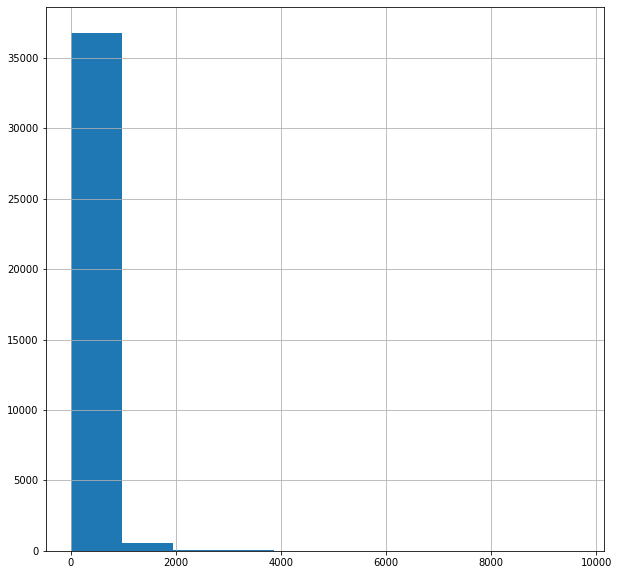

In [883]:
df["Number of Reviews"].hist()

Let's take squares of values for better visibility

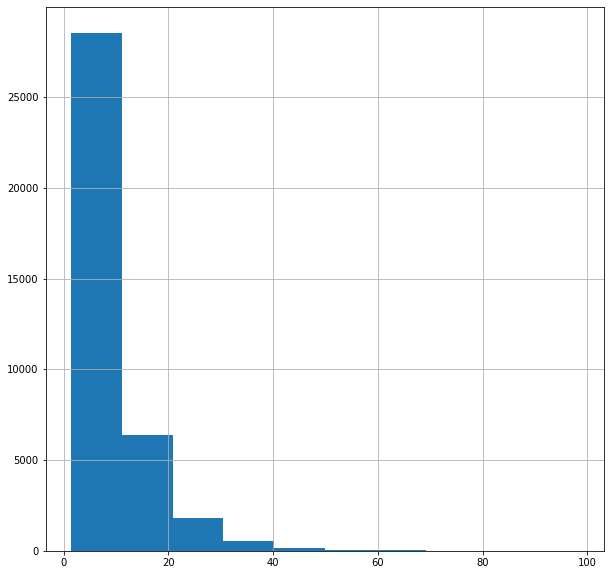

In [884]:
np.sqrt(df["Number of Reviews"]).hist()

Let's see a boxplot and colculate of outliers limits:

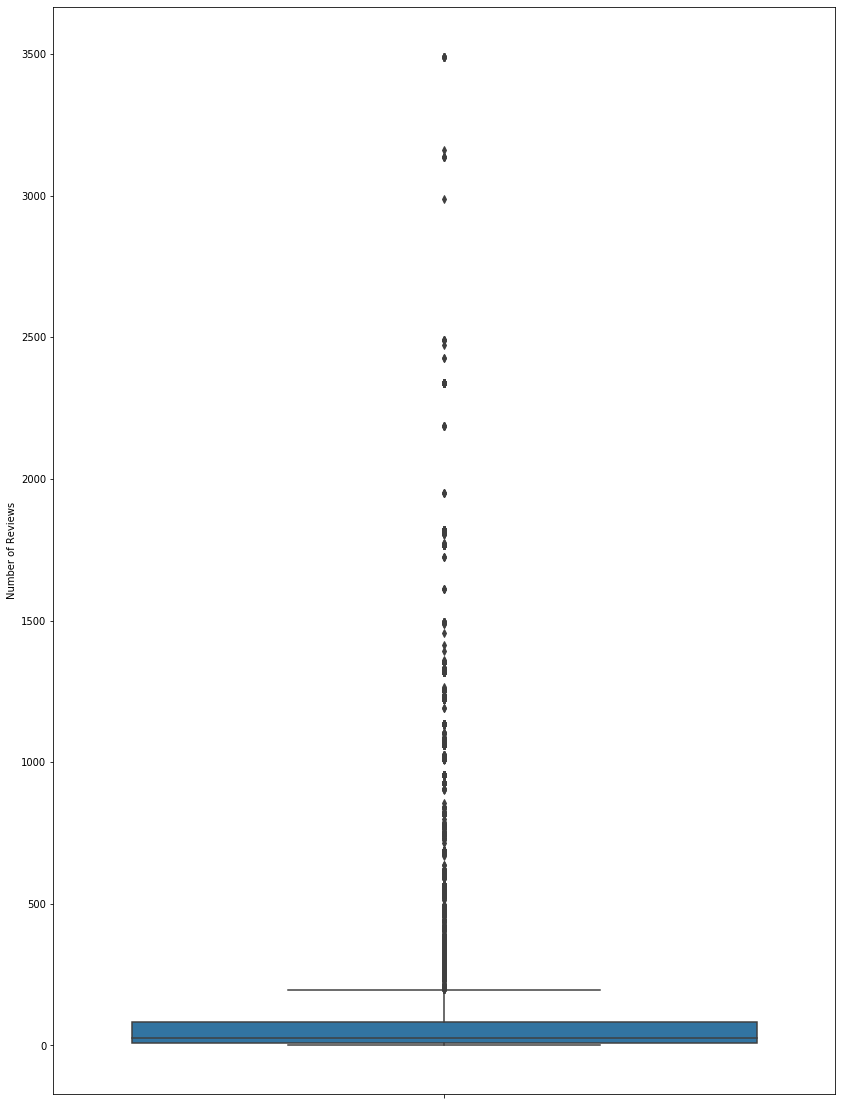

In [885]:
fig, ax = plt.subplots(figsize = (14, 20))
sns.boxplot( y=df["Number of Reviews"], data=df["Number of Reviews"], ax=ax)
plt.show()
            

In [886]:
#function for percentiles, IQR and outliers
def range_outliers(x):
    xmedian=x.median()
    xperc25=x.quantile(0.25)
    xperc75=x.quantile(0.75)
    xIQR=xperc75-xperc25
    print('median:{},'.format(xmedian),'25% percentile:{},'.format(xperc25), '75% percentile:{},'.format(xperc75), 'IQR:{},'.format(xIQR), 'limits of outliers: [{f},{l}]'.format(f=xperc25-1.5*xIQR, l=xperc75+1.5*xIQR))

In [887]:
range_outliers(df["Number of Reviews"])

median:33.0, 25% percentile:9.0, 75% percentile:115.0, IQR:106.0, limits of outliers: [-150.0,274.0]


As we see the median value fits better then mean for filling the blanks.

In [888]:
df["Number of Reviews"].fillna(df["Number of Reviews"].median(), inplace=True)


# Feature Processing

Let's clean 'Cuisine Style'.

In [889]:
df['Cuisine Style']=df['Cuisine Style'].str.replace('[', '')
df['Cuisine Style']=df['Cuisine Style'].str.replace(']', '')
df['Cuisine Style']=df['Cuisine Style'].str.replace("'", "")
df['Cuisine Style']=df['Cuisine Style'].str.replace(" ", "")
df['Cuisine Style']=df['Cuisine Style'].str.split(',')



Let's define the most popular cuisine styles and count how many of them have restaurants.

In [890]:
popular_styles=set(styles_counted_df[styles_counted_df>1500].index)

In [891]:
def popular(row):
    a=0
    for i in row['Cuisine Style']:
        if i in popular_styles:
            a+=1    
    return a
    

In [892]:
df['Popular Cuisine']=df.apply(popular, axis=1)

We can also pick out the information whether restaurant vegetarian friendly and bar (pub) in new columns

In [893]:
def veggy(row):
    v=0
    for i in row['Cuisine Style']:
        if i=='VegetarianFriendly':
            v+=1
        
    return v
        

In [894]:
def bar(row):
    
    b=0
    for i in row['Cuisine Style']:
        if (i=='Bar') or (i=='Pub'):
            b+=1
        
    return b

In [895]:
df['Veggy']=df.apply(veggy, axis=1)

In [896]:
df['Bar']=df.apply(bar, axis=1)

Let's define a populat cities

In [897]:
popular_city=set(df['City'].value_counts()[0:5].index)

In [898]:
def pop_city(row):
    if (row['City']=='Barcelona') or (row['City']=='Berlin') or (row['City']=='London') or (row['City']=='Madrid') or (row['City']=='Paris'):
        return 1
    else:
        return 0

In [899]:
df['Popular City']=df.apply(pop_city, axis=1)

In the column 'Reviews' we have some usefull information about dates of reviews. Let's get it from string values. We will use replace function with regular expression.

In [900]:
regex_pat = re.compile('[^0-9/,]', flags=re.IGNORECASE) 
df['Date']=df['Reviews'].str.replace(regex_pat, '', regex=True)
df['Date']=df['Date'].str.split(',')

Let's make a function, that will define and convert dates and ignore exceptions: 

In [901]:
def datefunc(row):
    dt=[]
    for i in row['Date']:
        try:
            a=datetime.strptime(i, '%m/%d/%Y')
            dt.append(datetime.strptime(i, '%m/%d/%Y'))
        except:
            continue
    return dt

In [902]:
df['Date']=df.apply(datefunc, axis=1)

Now we have the 'Date' column and can define the time difference between the review's date and some constant date.

In [903]:
maxdate=datetime(2020,12,31,0,0,0)

In [904]:
def fill_first(row):
    try:
        return (maxdate-row['Date'][0]).days
    except:
    
        return None
        

In [905]:
def fill_second(row):
    try:
        return (maxdate-row['Date'][1]).days
    except:
    
        return None
        

In [906]:
df['Timedelta_01']=df.apply(fill_first, axis=1)

In [907]:
df['Timedelta_02']=df.apply(fill_second, axis=1)

In [908]:
df['Timedelta_01']=df['Timedelta_01'].fillna(df['Timedelta_01'].median())
df['Timedelta_02']=df['Timedelta_02'].fillna(df['Timedelta_02'].median())
df['Timedelta_03']=df['Timedelta_02']-df['Timedelta_01']

Let's convert some categorical variables into dummy variables with pandas.get_dummies()

In [909]:
#df=pd.get_dummies(df, columns=['Price Range'])

Let's make lentgh of each review as a column

In [910]:
def lenrev(row):
    return len(row['Reviews'])

In [911]:
df['len_rev']=df.apply(lenrev, axis=1)

Restaurant_id        0
City                 0
Cuisine Style        0
Ranking              0
Rating               0
Price Range          0
Number of Reviews    0
Reviews              0
URL_TA               0
ID_TA                0
Popular Cuisine      0
Veggy                0
Bar                  0
Popular City         0
Date                 0
Timedelta_01         0
Timedelta_02         0
Timedelta_03         0
len_rev              0
Additional           0
dtype: int64

Let's make some more visualisation of the features

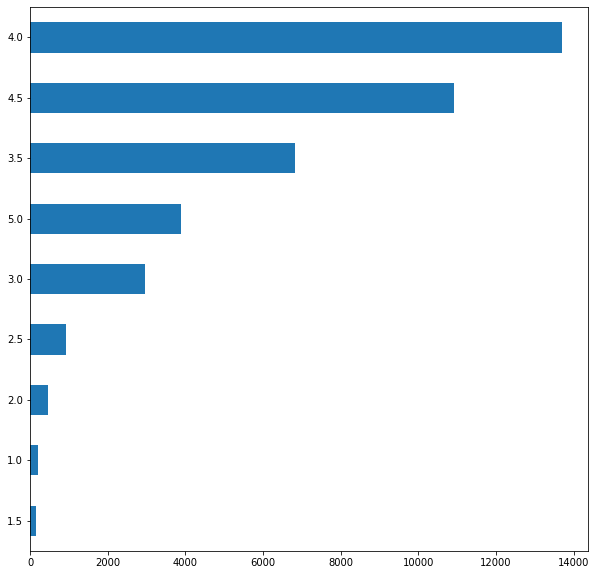

In [913]:
df['Rating'].value_counts(ascending=True).plot(kind='barh')

Let's see the relation of Rating and Ranking:

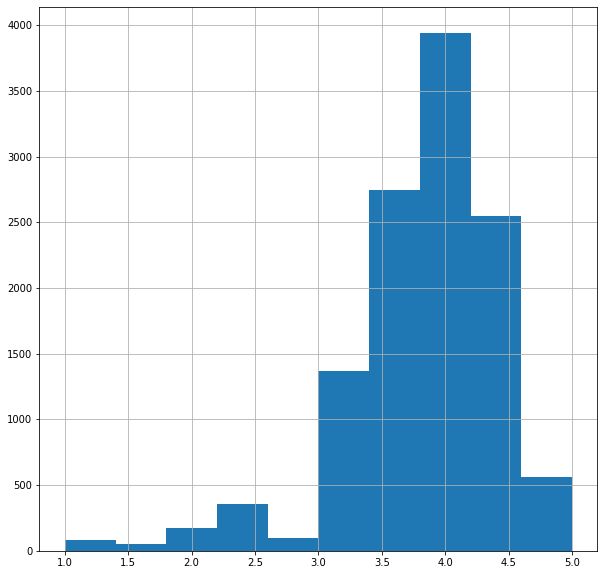

In [914]:
df.groupby(['Ranking'])['Rating' ].mean().hist()

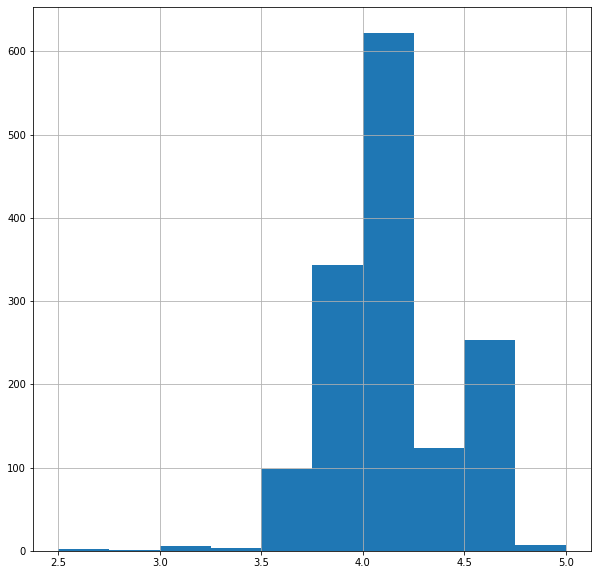

In [915]:
df.groupby(['Number of Reviews'])['Rating'].mean().hist()

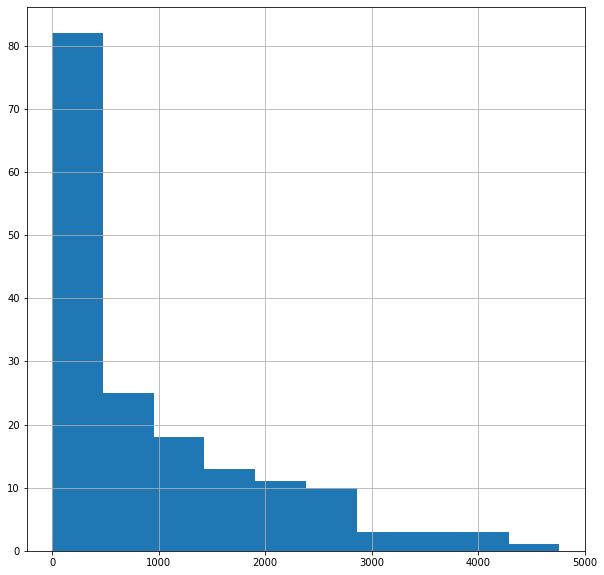

In [916]:
df[df['Rating'] == 5].groupby(['Number of Reviews'])['Ranking'].mean().hist()

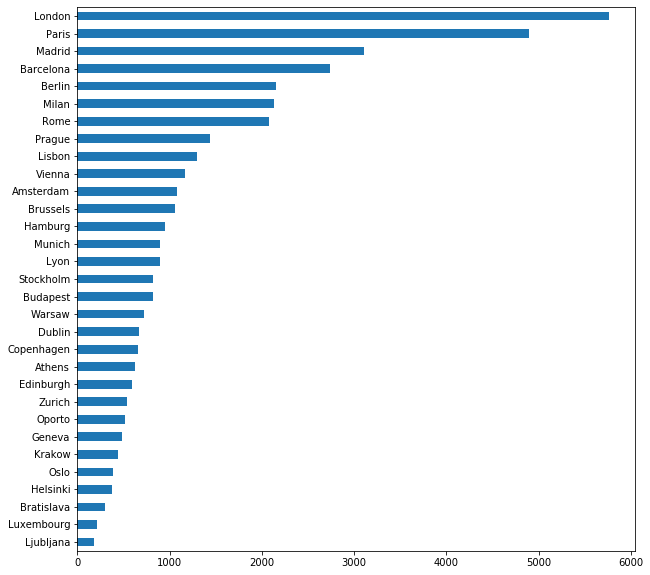

In [917]:
df['City'].value_counts(ascending=True).plot(kind='barh')

Let's pick out one more feature:

In [918]:
def additional(row):
    if (row['Ranking']>2500) and (row['Number of Reviews']>500):
        return 2
    if (row['Ranking']<500) and (row['Number of Reviews']<50):
        return 0
    else:
        return 1

In [919]:
df['Additional']=df.apply(additional, axis=1)

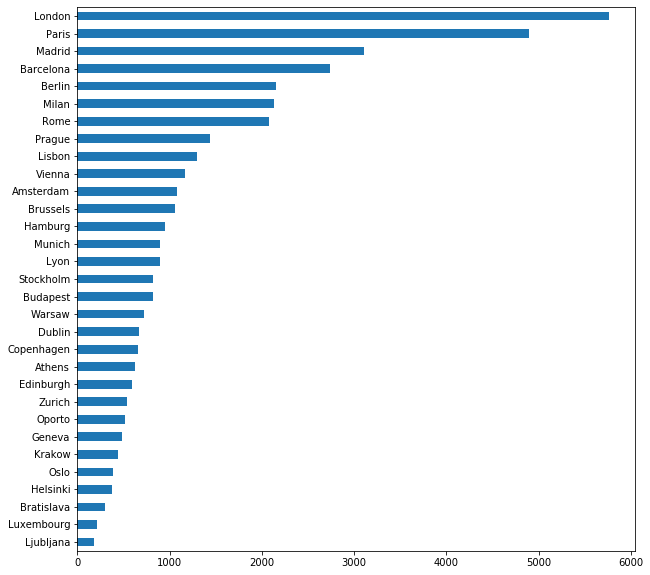

In [920]:
df['City'].value_counts(ascending=True).plot(kind='barh')

Let's split our DataFrame to Data set for training of our model and the target value. 

In [921]:
X = df.drop(['Restaurant_id', 'Rating', 'City', 'Reviews', 'Date', "Timedelta_02" , 'Cuisine Style', 'URL_TA', 'ID_TA', 'Additional',  'Date', ], axis = 1) 
y = df['Rating']


Let's see the correlations:

In [922]:
X.corr()

,Ranking,Price Range,Number of Reviews,Popular Cuisine,Veggy,Bar,Popular City,Timedelta_01,Timedelta_03,len_rev
Ranking,1.000000,-0.243553,-0.220005,-0.286439,-0.300139,-0.028040,0.594109,0.166851,-0.011805,-0.138552
Price Range,-0.243553,1.000000,0.306522,0.472850,0.447498,0.155221,0.006317,-0.222741,0.064081,0.434038
Number of Reviews,-0.220005,0.306522,1.000000,0.411186,0.360999,0.048448,-0.019989,-0.173181,-0.013682,0.180115
Popular Cuisine,-0.286439,0.472850,0.411186,1.000000,0.698555,0.291659,-0.018520,-0.265359,-0.007523,0.294279
Veggy,-0.300139,0.447498,0.360999,0.698555,1.000000,0.034409,-0.019778,-0.255776,-0.008609,0.306629
Bar,-0.028040,0.155221,0.048448,0.291659,0.034409,1.000000,-0.003090,-0.090891,0.002501,0.093532
Popular City,0.594109,0.006317,-0.019989,-0.018520,-0.019778,-0.003090,1.000000,0.006806,-0.003723,0.004042
Timedelta_01,0.166851,-0.222741,-0.173181,-0.265359,-0.255776,-0.090891,0.006806,1.000000,-0.463075,-0.013415
Timedelta_03,-0.011805,0.064081,-0.013682,-0.007523,-0.008609,0.002501,-0.003723,-0.463075,1.000000,0.188899
len_rev,-0.138552,0.434038,0.180115,0.294279,0.306629,0.093532,0.004042,-0.013415,0.188899,1.000000


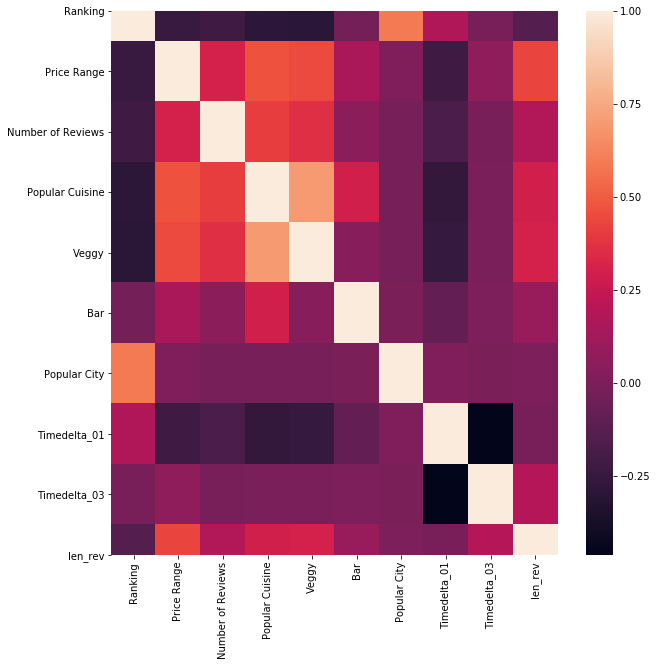

In [923]:
sns.heatmap(X.corr())

In [924]:
#Popular Cuisine	Veggy	Bar	Popular City	Date	Timedelta_01	Timedelta_02	Timedelta_03	len_rev	Additional


Now we will split datasets into random train and test subsets:

In [925]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


Let's create a model:

In [926]:
regr = RandomForestRegressor(n_estimators=100)

Let's train the model on a test dataset:

In [927]:
regr.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Using our model for prediction restautant's rating save the predicted values:

In [928]:
y_pred = regr.predict(X_test) 

Mean Absolute Error:

In [929]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.34280624285714284


Let's see wich of the features have a biggest influence to our prediction 

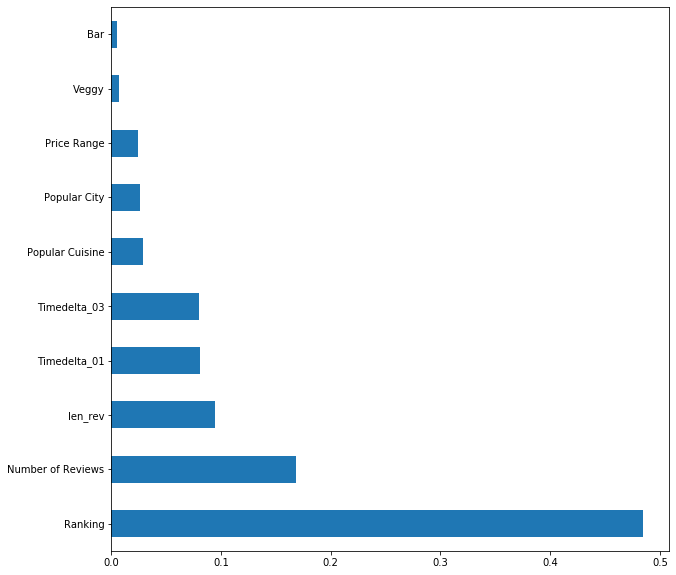

In [930]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')